$
\newcommand{\Tau}{\mathcal{T}}
\newcommand{\bm}[1]{{\boldsymbol{#1}}}
\newcommand{\dt}[1]{{\frac{d#1}{dt}}}
%\newcommand{\bm}{\mathbf{#1}}
\newcommand{\trsp}{{\scriptscriptstyle\top}}$

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pbdlib as pbd
from scipy.io import loadmat # loading data from matlab

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Hidden Markov Model and LQR
This is an example of learning a HMM over some trajectories demonstrations and reproducing it using optimal control.
More infos : http://calinon.ch/papers/Calinon-JIST2015.pdf 


## Learning Hidden Markov Model (HMM)

In [2]:
datapath = os.path.dirname(pbd.__file__) + '/data/gui/'
data = np.load(datapath + 'test_001.npy',allow_pickle=True,encoding="latin1")[()] 
# adding encoding="latin1" for reading Python2 objects.

In [3]:
demos_x = data['x']  #Position data
demos_dx = data['dx'] # Velocity data
demos_xdx = [np.hstack([_x, _dx]) for _x ,_dx in zip(demos_x, demos_dx)] # Position-velocity

# Time aligning

#### Original trajectories 

/home/agrolegion/.local/lib/python2.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


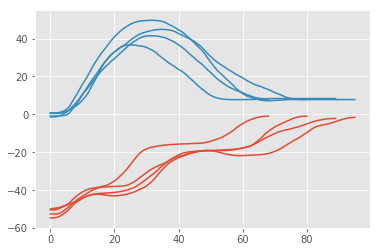

In [4]:
for d in demos_x:
    plt.axes().set_prop_cycle(None)
    plt.plot(d)

In [5]:
demos_x, demos_dx, demos_xdx = pbd.utils.align_trajectories(demos_x, [demos_dx, demos_xdx]) 

t = np.linspace(0, 100, demos_x[0].shape[0])

#### Aligned trajectories and time

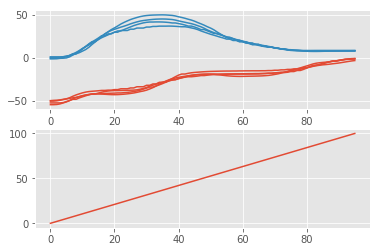

In [6]:
fig, ax = plt.subplots(nrows=2)
for d in demos_x:
    ax[0].set_prop_cycle(None)
    ax[0].plot(d)
    
ax[1].plot(t)

## Create augmented data with time 

In [7]:
demos = [np.hstack([t[:,None], d]) for d in demos_xdx]
data = np.vstack([d for d in demos])

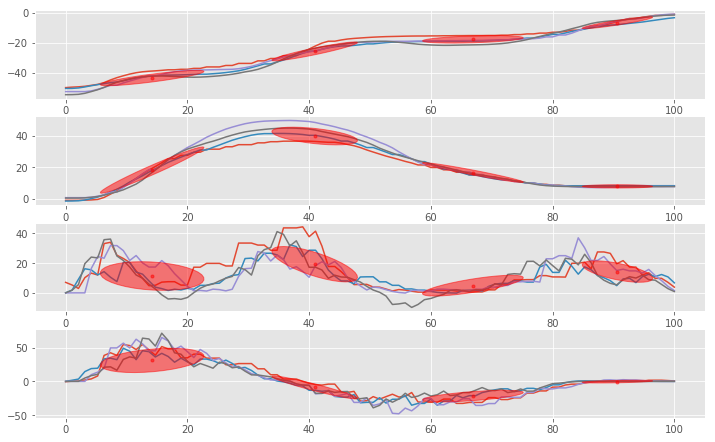

In [8]:
model = pbd.GMM(nb_states=4, nb_dim=5)

model.init_hmm_kbins(demos) # initializing model

# EM to train model
model.em(data, reg=[0.1, 1., 1., 1., 1.]) 


# plotting
fig, ax = plt.subplots(nrows=4)
fig.set_size_inches(12,7.5)

# position plotting

for i in range(4):

    for p in demos:
        ax[i].plot(p[:, 0], p[:, i + 1])

    pbd.plot_gmm(model.mu, model.sigma, ax=ax[i], dim=[0, i + 1]);


## Synthesis 

In [9]:
mu, sigma = model.condition(t[:, None], dim_in=slice(0, 1), dim_out=slice(1, 5))

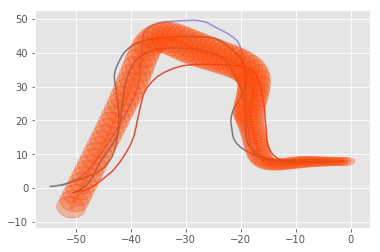

In [10]:
pbd.plot_gmm(mu, sigma, dim=[0, 1], color='orangered', alpha=0.3)

for d in demos_x:
    plt.plot(d[:, 0], d[:, 1])